**Data Augmentation**

In this lab, we train a Convolutional Neural Network with Regular data and Augmented data. The purpose of this lab is to show that the Augmented data improvesgeneralization performance.

Think of a scenario where a drone has to take a picture of an object. The drone is moving and the object can also possibly be moving. When an image is taken we arent always going to get perfect images. The subject may not be perfectly centered in the image or the subject may be rotated in the image. In this case, a model trained on perfectly centered or rotated images won't perform well. This is why we train a model on rotated data so it can perform well on imperfect images.

In this assignment, we will use a dataset of digit images. We will have two models, one trained on non rotated digits and one trained on rotated images and then we will test the models.

In [1]:
#!pip3 install torch torchvision torchaudio

In [2]:
#Downloading a pretrained model
import urllib.request

url = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/normal.pt"
filename = "normal.pt"

try:
    urllib.request.urlretrieve(url, filename)
    print("File downloaded successfully:", filename)
except Exception as e:
    print("Error downloading the file:", e)


File downloaded successfully: normal.pt


In [3]:
#Downloading a pretrained model on Augmented data
import urllib.request

url = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/rotated_data.pt"
filename = "rotated_data.pt"

try:
    urllib.request.urlretrieve(url, filename)
    print("File downloaded successfully:", filename)
except Exception as e:
    print("Error downloading the file:", e)


File downloaded successfully: rotated_data.pt


In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import numpy as np
import torchvision.datasets as dsets
import os

Some useful functions for plotting

In [5]:
#Plotting Cost & Accuracy vs Epoch Graph
def plot_cost_accuracy(checkpoint):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(checkpoint['cost'], color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('cost', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()#is used to create a second y-axis on the right side of the plot, which shares the same x-axis as ax1. This is useful when you want to plot two different datasets with different scales on the same graph.
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.set_xlabel('epoch', color=color)
    ax2.plot(checkpoint['accuracy'], color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

In [6]:
#Defining the function 'show_data' to plot out data samples as images.
def show_data(data_samples):
    plt.imshow(data_samples[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y= ' + str(data_samples[1]))

In [7]:
#Plotting first 5 misclassified samples.
def plot_mis_class(model, dataset):
    count=0
    for x, y in torch.utils.data.DataLoader(dataset=dataset, batch_size=1):
        z = model(x)
        _, yhat = torch.max(z, 1)
        if yhat != y:
            show_data((x,y))
            plt.show()
            count += 1
        if count >= 10:
            break

**Load Data**

In [8]:
#Image size 16x16
IMAGE_SIZE = 16
#Resize the image, randomaly rotate, convert it to a tensor #from "import torchvision.transforms as transforms"
compose_rotate = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.RandomAffine(45), transforms.ToTensor()])
#Resize the image, convert it to a tensor
compose = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [9]:
train_dataset_rotate = dsets.MNIST(root='./data', train=True, download=True, transform=compose_rotate)
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=compose)

In [10]:
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=compose_rotate)
#As we want to test both the rotated and nonrotated training test on rotated datasets

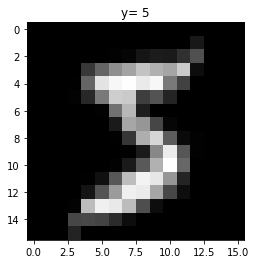

In [11]:
show_data(train_dataset_rotate[0])

In [12]:
train_dataset_rotate[0][1] #Label for the first data

5

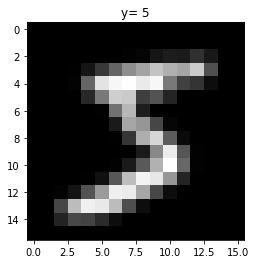

In [13]:
show_data(train_dataset[0])

In [14]:
train_dataset[0][1]

5

**Building a Convolution Neural Network Class**

Building a Convolutional Network class with 2 layers and 1 fully connected layer. Pre-determine the size of final output matrix. The parameters in the constructor are the number of output channels for the first and second layers.

In [15]:
class CNN (nn.Module):
    #Constructor
    def __init__(self, out_1=16, out_2=32):
        super().__init__()
        
        # 1 channel for single black and white image
        #Channel width after this layer is 16
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        #channel width after this layer is 8
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        #channel width after this layer is 4
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        #In total we have out_2 = 32 channels which are each 4*4 in size based on the width calculation above. Channels are squares.
        self.fc1 = nn.Linear(out_2*4*4,10)
        
    #Prediction
    def forward(self, x):
        #Puts the x value through each cnn, relu, and pooling layer and it is flattened for input into the fully connected layer.
        x=self.cnn1(x)
        x=torch.relu(x)
        x=self.maxpool1(x)
        x=self.cnn2(x)
        x=torch.relu(x)
        x=self.maxpool2(x)
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        return x
    
    #Output of each stage in CNN, ReLU, and pooling layers
    def activations(self, x):
        a1 = self.cnn1(x)
        a2 = torch.relu(a1)
        a3 = self.maxpool1(a2)
        
        b1 = self.cnn2(x)
        b2 = torch.relu(b1)
        b3 =self.maxpool1(b2)
        a3 = a3.view(a3.size(0), -1) #It is not necessary to flatten the tensor, as it is not applicable for the further process. It's just for visualization.
        return a1,a2,a3,b1,b2,b3

**Regular Data**

Defining the Convolutional Neural Network Classifier, Criterion function, optimizer, Train the model


In [16]:
#Create the model object to be trained on regular darta using CNN class.
model = CNN(out_1=16, out_2=32)

In [17]:
#Criterion to measure loss:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
#Creating data loader for the rotated validation data with a batch size of 5000
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

**Training the Model** (on Non-rotated tested data)

In [18]:
#Train the model
import os

#Location to save the data
file = os.path.join(os.getcwd(), 'normal.pt')

#All the data we are saving
checkpoint={#Saving the number of epochs
'epoch': None,
#Saving the models parameters which will allow us to recreate the trained model
'model_state_dictionary': None,
#Saving the optimizers parameters
'optimizer_state_dictionary': None,
#Saving the loss on the training dataset for the last batch of the last epoch
'loss':None,
#Saving the cost on the training dataset for each epoch
'cost':[],
#saving the accuracy for the testing dataset for each epoch
'accuracy': []}

#Number of epochs to train the model
n_epochs = 10

#Size of testing dataset
N_test = len(validation_dataset) #For batch sizing

#Training for the number of epochs we want
for epoch in range(n_epochs):
    #Variable to track cost for ea each epoch
    cost = 0
    #For each batch in the training dataset
    for x, y in train_loader:
        #Resting gradient value.
        optimizer.zero_grad()
        #Making the prediction on an image.
        z = model(x)
        #Calculating the loss between prediction and actual class.
        loss = criterion(z, y)
        #Calculating the gradient value with respect to each weight and bias.
        loss.backward()
        #Uppdates the weight and bias according to calculated gradient value.
        optimizer.step()
    
        #Save the number of epochs we trained for
        checkpoint['epoch'] = n_epochs
        #Saves the model parameters(saving weights and biases)
        checkpoint['model_state_dictionary'] = model.state_dict()
        #Saves the optimizers parameters
        checkpoint['optimizer_state_dictionary'] = optimizer.state_dict()
        #Saves the loss of last batch of the epochs
        checkpoint['loss'] = loss.item()
        #Accumulate the loss
        cost += loss.item()
    
    #Count for the correct number of predictions
    correct = 0
    #For each batch in the validation dataset
    for x_test, y_test in validation_loader:
        #Make a prediction
        z = model(x_test)
        #Get the class that has maximum value
        _, yhat = torch.max(z.data, 1)
        #Counting the correct number of predictions
        correct += (yhat == y_test).sum().item()
    
    accuracy = correct/N_test
    print(accuracy)
    #Appent the cost of epoch to a list
    checkpoint['cost'].append(cost)
    #Append the accuracy of wpoch to a list
    checkpoint['accuracy'].append(accuracy)
    #Saves the data in checkpoint to the file location
    torch.save(checkpoint, file)



0.7596
0.7954
0.8014
0.8026
0.8075
0.805
0.8068
0.809
0.8127
0.8169


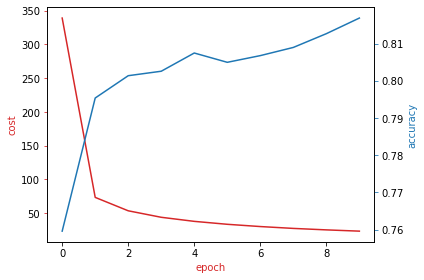

In [19]:
checkpoint_normal = torch.load(file)
plot_cost_accuracy(checkpoint)


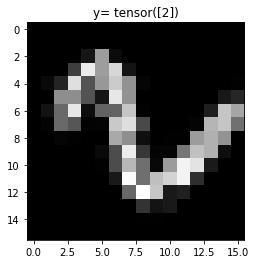

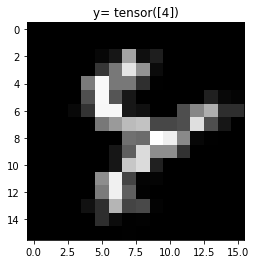

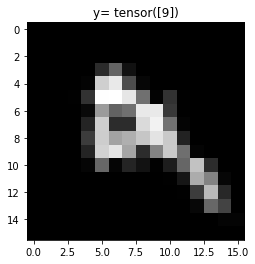

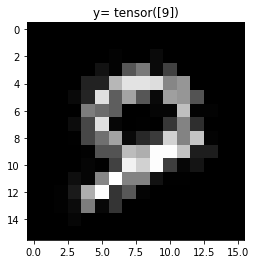

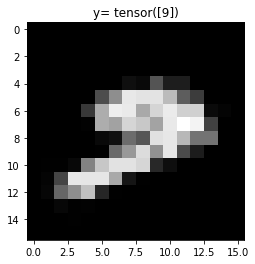

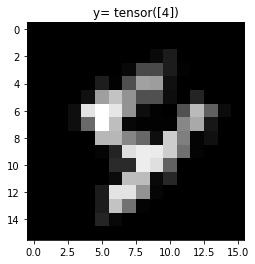

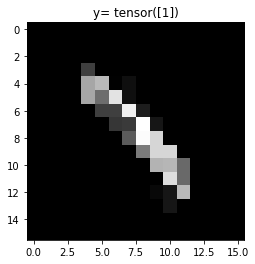

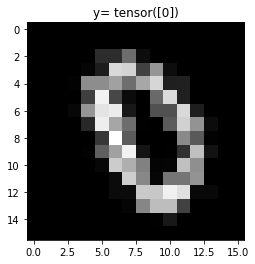

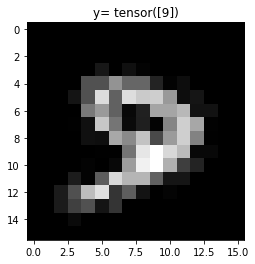

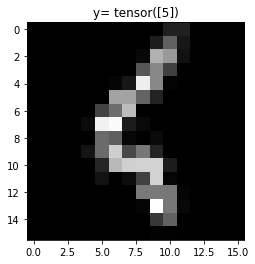

In [20]:
#Misclassified samples:
model.load_state_dict(checkpoint_normal['model_state_dictionary'])

plot_mis_class(model, validation_dataset)


**Rotated Training Data**

In [21]:
# Create the model object using CNN class
model_r = CNN(out_1=16, out_2=32)
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model_r.parameters(), lr = learning_rate)
# Create a Data Loader for the rotated training data with a batch size of 100 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_rotate, batch_size=100)
# Create a Data Loader for the rotated validation data with a batch size of 5000 
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [22]:
# Location to save data
file_rotated = os.path.join(os.getcwd(), 'rotated_data.pt')

# All the data we are saving
checkpoint={
            # Saving the number of epochs the models was trained for
            'epoch': None,
            # Saving the models parameters which will allow us to recreate the trained model
            'model_state_dict': None,
            # Saving the optimizers parameters
            'optimizer_state_dict': None,
            # Saving the loss on the training dataset for the last batch of the last epoch
            'loss': None,
            # Saving the cost on the training dataset for each epoch
            'cost': [],
            # Saving the accuracy for the testing dataset for each epoch
            'accuracy': []}
            
# Number of epochs to train model            
n_epochs = 10

# Size of the testing dataset
N_test = len(validation_dataset)

# Training for the number of epochs we want
for epoch in range(n_epochs):
    # Variable to keep track of cost for each epoch
    cost = 0
    # For each batch in the training dataset
    for x, y in train_loader:
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Makes a prediction on the image
        z = model_r(x)
        # Calculate the loss between the prediction and actual class
        loss = criterion(z, y)
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
      
        # Saves the number of epochs we trained for  
        checkpoint['epochs'] = n_epochs
        # Saves the models parameters
        checkpoint['model_state_dict'] = model.state_dict()
        # Saves the optimizers paramters
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        # Saves the loss for the last batch so ultimately this will be the loss for the last batch of the last epoch
        checkpoint['loss'] = loss
        # Accumulates the loss
        cost+=loss.item()
        
     
    # Counter for the correct number of predictions        
    correct = 0
        
    # For each batch in the validation dataset
    for x_test, y_test in validation_loader:
        # Make a prediction
        z = model_r(x_test)
        # Get the class that has the maximum value
        _, yhat = torch.max(z.data, 1)
        # Counts the number of correct predictions made
        correct += (yhat == y_test).sum().item()
 
    accuracy = correct / N_test
    print(accuracy)
    # Appends the cost of the epoch to a list
    checkpoint['cost'].append(cost) 
    # Appends the accuracy of the epoch to a list
    checkpoint['accuracy'].append(accuracy)
    # Saves the data in checkpoint to the file location
    torch.save(checkpoint, file_rotated) 

0.9111
0.9355
0.9396
0.95
0.9526
0.9557
0.9572
0.9578
0.961
0.9588


In [23]:
checkpoint_rotated = torch.load(os.path.join(os.getcwd(),'rotated_data.pt'))

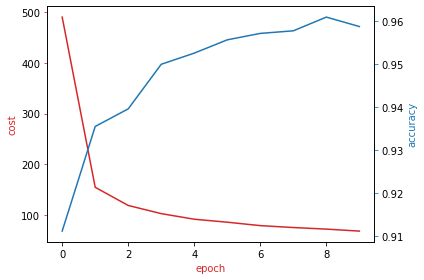

In [25]:
plot_cost_accuracy(checkpoint_rotated)

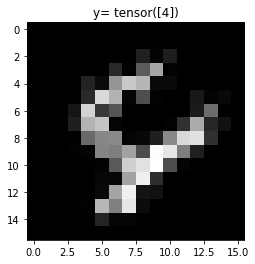

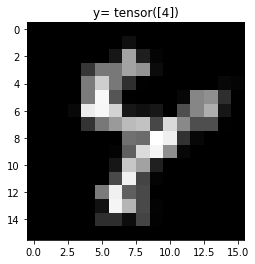

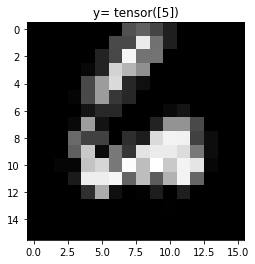

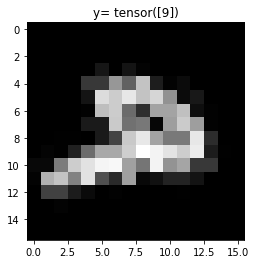

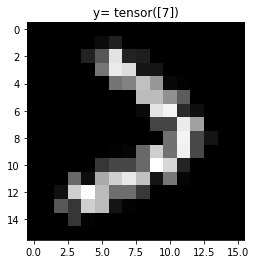

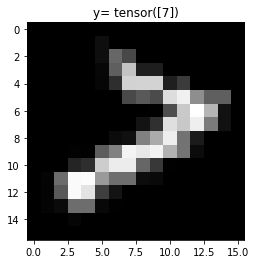

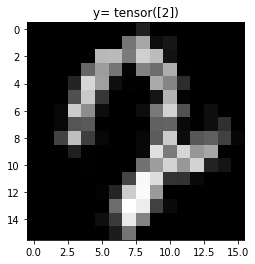

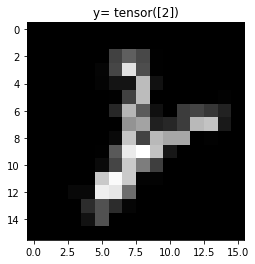

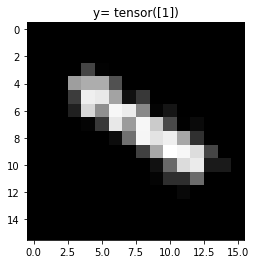

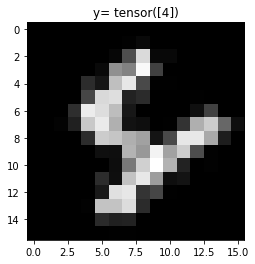

In [27]:
# Using the model parameters we saved we load them into a model to recreate the trained model
model_r.load_state_dict(checkpoint_rotated['model_state_dict'])

# Using the helper function plot the first five misclassified samples
plot_mis_class(model_r,validation_dataset)